# Building an MPS as a tree and using TEBD for time-evolution
A matrix product state (MPS) is a binary tree. Therefore, we can simulate it using `PyTreeNet`. We recommend to use tensor network libraries specialised on MPS for serious simulation, due to a higher efficiency. However, utilising `PyTreeNet` on MPS is useful as an illustrative example and to test the code for mistakes, by comparing to the results yielded by the easy to implement few-site dynamics.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import expm
from copy import copy, deepcopy

from pytreenet.operators import pauli_matrices, TensorProduct
from pytreenet.special_ttn import MatrixProductState
from pytreenet.time_evolution import TEBD, ExactTimeEvolution, TrotterSplitting, TrotterStep
from pytreenet.util import SVDParameters

We want to analyse a chain of $N$-many qubits that evolves under an Ising Hamiltonian of the form
$$
H = -J \sum_{n=0}^{N-2} X_n X_{n+1} - g \sum_{n=0}^{N-1} Z_n.
$$

As a first step we will initalise a tree tensor network (TTN) representing an MPS in the initial state where all qubits are in the state $|0>$

## Setting up and running TEBD

Since the total zero state is a product state, we can create its MPS form by adding one node after the other to a tree tensor network state.

In [23]:
num_sites = 7
init_state = 0
dimension = 2
root_site = int(num_sites/2)
mps = MatrixProductState.constant_product_state(init_state,
                                                    dimension,
                                                    num_sites,
                                                    root_site=root_site)

We find the TTN contains all the desired sites as nodes and is normalised. Note that the open leg was moved to be the last leg rather then the middle one, which is commonly done in MPS libraries.

In [24]:
print(mps)
print(f"Norm = {np.sqrt(mps.scalar_product())}")

site0 : (1, 2)
site1 : (1, 1, 2)
site2 : (1, 1, 2)
site3 : (1, 1, 2)
site4 : (1, 1, 2)
site5 : (1, 1, 2)
site6 : (1, 2)

Norm = (1+0j)


For TEBD the time-evolution is computed via a Trotter splitting. Deciding on the exact form of the splitting is a balancing act between accuracy and computing resources. As a simple case we will choose the first order splitting:
$$
U(\delta t) = e^{-i\delta t H} = \prod_{n=0}^{N-1} e^{i\delta t \, J X_n X_{n+1}} \prod_{n=0}^{N-1} e^{i\delta t \, g Z_n} + \mathcal{O} (\delta t^2)
$$
We need to define the operators making up the Hamiltonian of our model. Every term is its own operator and in tensor product form.

In [25]:
# Define constants
mJ = -1.5
mg = -0.5

# Define operators
X, _, Z = pauli_matrices()
gZ = mg * Z
hamiltonian_operators = []

# Add the two-site interaction
for site in range(0,num_sites-1): # There is no interaction of the form X_N*X_{N+1}
    term = TensorProduct({"site" + str(site): mJ * X, "site" + str(site +1): X})
    hamiltonian_operators.append(term)
    
# Add local interactions
for site in range(0,num_sites):
    term = TensorProduct({"site" + str(site): gZ})
    hamiltonian_operators.append(term)
    
print(hamiltonian_operators)

[{'site0': array([[-0. +0.j, -1.5+0.j],
       [-1.5+0.j, -0. +0.j]]), 'site1': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}, {'site1': array([[-0. +0.j, -1.5+0.j],
       [-1.5+0.j, -0. +0.j]]), 'site2': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}, {'site2': array([[-0. +0.j, -1.5+0.j],
       [-1.5+0.j, -0. +0.j]]), 'site3': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}, {'site3': array([[-0. +0.j, -1.5+0.j],
       [-1.5+0.j, -0. +0.j]]), 'site4': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}, {'site4': array([[-0. +0.j, -1.5+0.j],
       [-1.5+0.j, -0. +0.j]]), 'site5': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}, {'site5': array([[-0. +0.j, -1.5+0.j],
       [-1.5+0.j, -0. +0.j]]), 'site6': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}, {'site0': array([[-0.5+0.j, -0. +0.j],
       [-0. +0.j,  0.5-0.j]])}, {'site1': array([[-0.5+0.j, -0. +0.j],
       [-0. +0.j,  0.5-0.j]])}, {'site2': array([[-0.5+0.j, -0. +0.j],
       [-0. +0.j,  0.5-0.j

Since TEBD is based on splitting the terms one by one, we need to define, in which order the terms are to be applied.

In [29]:
# Now we initialise the splitting order for both splittings
splitting1st = [2*i for i in range(0, int(num_sites/2))]
splitting1st.extend([2*i +1 for i in range(0, int(num_sites/2))])
splitting1st.extend([i + num_sites -1 for i in range(0,num_sites)])
print("1st order splitting:", splitting1st)

steps = [None] * len(splitting1st)
for i in splitting1st:
    step = TrotterStep(hamiltonian_operators[i], 1)
    steps[i] = step

# Thus we have everything required for the TrotterSplitting which holds everything required for the splitting.
# Note that for higher order, factors can be added to the splitting and we can have swap gates applied in between
# two operators.
trotter1st = TrotterSplitting(steps)

1st order splitting: [0, 2, 4, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12]


Finally we can set up the TEBD simulation.

In [34]:
# Time parameters
time_step_size = 0.01
final_time = 1

# Truncation parameters
max_bond_dim = 20
rel_tol = 1e-16
svd_params = SVDParameters(max_bond_dim,rel_tol)

# We want to observe the evolution of the Z-operator expectation at each site.
tebd_operators = {f"site{i}": TensorProduct({f"site{i}": Z}) for i in range(num_sites)}

# We instantiate the TEBD simulations. To keep them independent, the MPS has to be copied.
tebd_sim_1st = TEBD(deepcopy(mps),
                    trotter1st,
                    time_step_size=time_step_size,
                    final_time=final_time,
                    operators=tebd_operators,
                    svd_parameters=svd_params)

# After the set up is complete, we merely have to run the simulation
tebd_sim_1st.run()

100%|██████████| 101/101 [00:00<00:00, 109.91it/s]


## Running the reference matrix vector computation
### Non-Trotterised
As a reference we will run a computation on a full state vector. Thus we have to reinitialise the initial state:

In [32]:
zero_state = np.asarray([1,0])
ref_state = zero_state

for site in range(1, num_sites):
    ref_state = np.kron(ref_state, zero_state)
    
print(f"Initial state {ref_state} is a vector with 2^{num_sites}={len(ref_state)} entries.")

Initial state [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] is a vector with 2^7=128 entries.


Furthermore we need to initialise the Hamiltonian as a matrix:

In [33]:
ref_hamiltonian = np.zeros((2**num_sites, 2**num_sites), dtype=complex)

I = np.eye(2)
J = -mJ

# Two-site terms
for site in range(0,num_sites-1):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        if site2 == site:
            operator = np.kron(operator, J*X)
        elif site2 == site+1:
            operator = np.kron(operator, X)
        else:
            operator = np.kron(operator, I)
    ref_hamiltonian += operator
    
# Single-site terms
for site in range(0,num_sites):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        if site2 == site:
            operator = np.kron(operator, gZ)
        else:
            operator = np.kron(operator, I)
    ref_hamiltonian += operator
    
print(f"The Hamiltonian is a {ref_hamiltonian.shape}-shaped matrix and contains (2^{num_sites})^2={len(ref_state)**2} entries.")

The Hamiltonian is a (128, 128)-shaped matrix and contains (2^7)^2=16384 entries.


As a final step of the set-up we have to define the operators from which we desire the expectation values.

In [35]:
ref_operators = {}
for site in range(num_sites):
    site_operator = np.asarray([1])
    for site2 in range(num_sites):
        if site2 == site:
            site_operator = np.kron(site_operator, Z)
        else:
            site_operator = np.kron(site_operator, I)
    ref_operators[f"site{site}"] = site_operator

We can finally run the time-evolution.

In [36]:
exact_evolution = ExactTimeEvolution(ref_state,
                                     ref_hamiltonian,
                                     time_step_size,
                                     final_time,
                                     ref_operators)
exact_evolution.run()

100%|██████████| 101/101 [00:00<00:00, 2752.88it/s]


We can do some sanity checks by using the methods of the `TimeEvolution` parent class.

In [37]:
print(exact_evolution.results_real())
exact_results = exact_evolution.operator_results(realise=True)
print(f"Results Shape: {exact_results.shape}")

True
Results Shape: (7, 101)


### Trotterised Computation
To ensure that the error is fully due to the Trotterisation, we run a time-evolution that evolves according to a Trotterisation.

In [46]:
# Creating the Trotter Steps
trotter_operators = []

# Two-site terms
for site in range(0,num_sites-1):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        if site2 == site:
            operator = np.kron(operator, J*X)
        elif site2 == site+1:
            operator = np.kron(operator, X)
        else:
            operator = np.kron(operator, I)
    trotter_operators.append(operator)
    
# Single-site terms
for site in range(0,num_sites):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        if site2 == site:
            operator = np.kron(operator, gZ)
        else:
            operator = np.kron(operator, I)   
    trotter_operators.append(operator)

num_time_steps = exact_evolution.num_time_steps
trotter_unitaries = [expm(-1j*time_step_size*term) for term in trotter_operators]
results_trotterised = {operator_id: np.zeros((num_time_steps + 1, ), dtype=complex)
                       for operator_id in ref_operators}
ref_state_trotter = zero_state
for site in range(1, num_sites):
    ref_state_trotter = np.kron(ref_state_trotter, zero_state)
for time_step in range(num_time_steps + 1):
    if time_step != 0:
        for unitary in trotter_unitaries:
            ref_state_trotter = unitary @ ref_state_trotter
    conj_state = np.conjugate(ref_state_trotter.T)
    for operator_id, operator in ref_operators.items():
        results_trotterised[operator_id][time_step] = conj_state @ operator @ ref_state_trotter

print(f"Result Shape: ({len(results_trotterised)}, {len(results_trotterised['site0'])})")

Result Shape: (7, 101)


## Extracting results from TEBD
The expectation values and times are saved in the attribute `TEBD.results`. They can both be recovered by using the methods of the `TimeEvolution` parent class:

In [47]:
times = tebd_sim_1st.times()
print(f"Results Real: {tebd_sim_1st.results_real()}")

Results Real: True


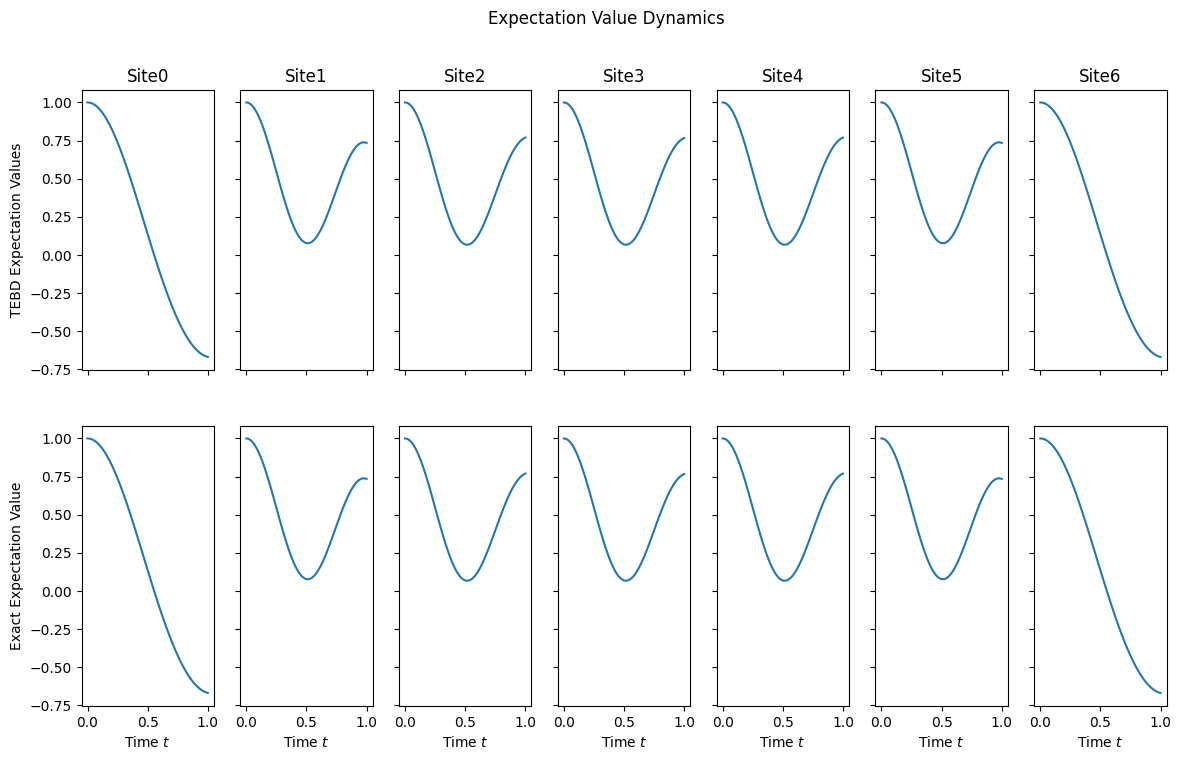

In [48]:
fig, axs = plt.subplots(2,7, sharex=True, sharey=True, figsize=(14,8))
fig.suptitle("Expectation Value Dynamics")

for site in range(num_sites):
    axs[0][site].set_title("Site" + str(site))
    axs[0][site].plot(times, tebd_sim_1st.operator_result(f"site{site}",realise=True))
axs[0][0].set_ylabel("TEBD Expectation Values")

for site in range(num_sites):
    axs[1][site].plot(times, exact_evolution.operator_result(f"site{site}",realise=True))
    axs[1][site].set_xlabel("Time $t$")
axs[1][0].set_ylabel("Exact Expectation Value")

plt.show()

We can already see that both are very similar. Let us compare the actual errors:

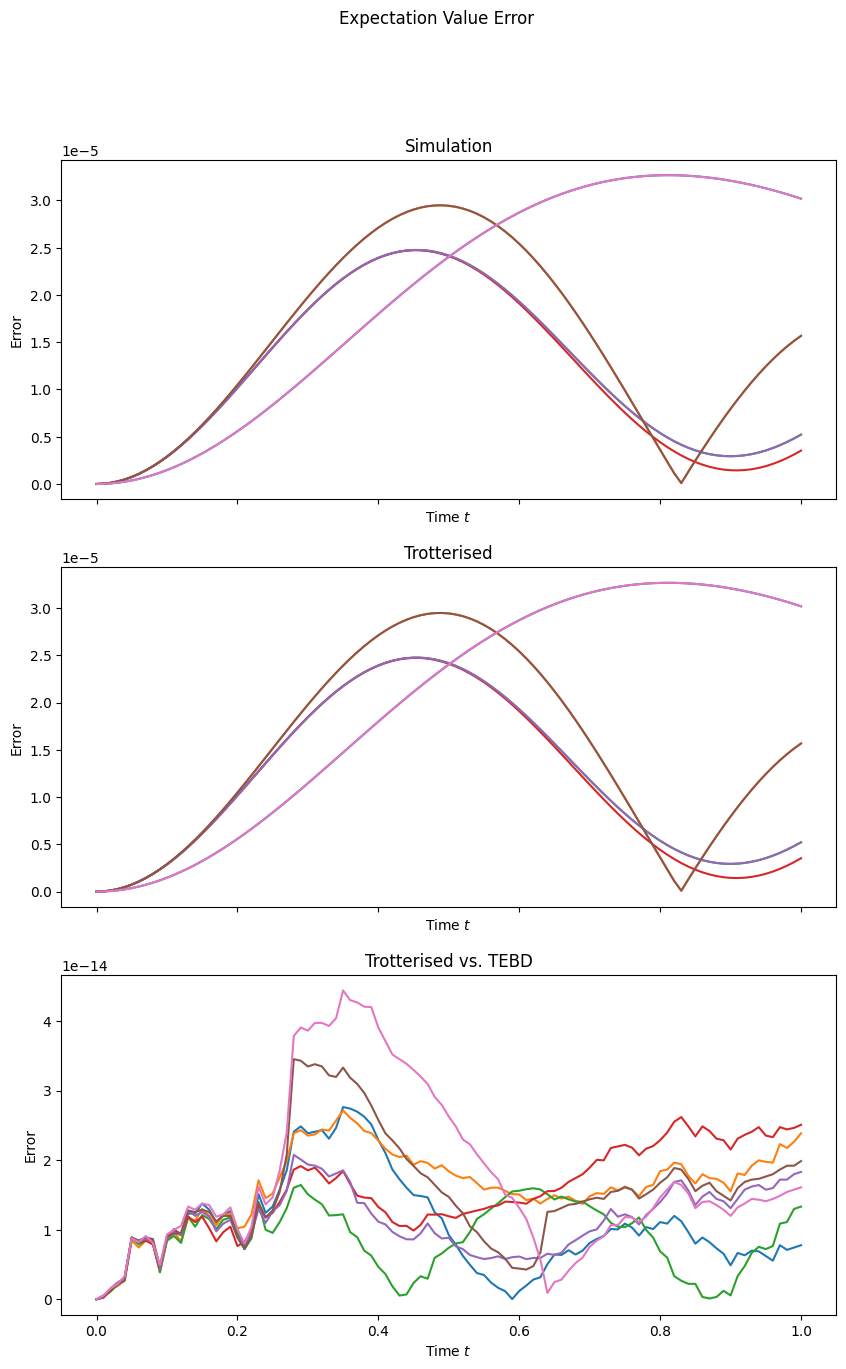

In [49]:
fig2, axs2 = plt.subplots(3,1, sharex=True, sharey=False, figsize=(10,15))

fig2.suptitle("Expectation Value Error")

for site in range(num_sites):
    exact_results_site = exact_evolution.operator_result(f"site{site}",realise=True)
    tebd_results_site = tebd_sim_1st.operator_result(f"site{site}",realise=True)
    error = np.abs(exact_results_site - tebd_results_site)
    axs2[0].plot(times, error)
axs2[0].set_xlabel("Time $t$")
axs2[0].set_ylabel("Error")
axs2[0].set_title("Simulation")

for site in range(num_sites):
    exact_results_site = exact_evolution.operator_result(f"site{site}",realise=True)
    trotter_results_site = results_trotterised[f"site{site}"]
    error = np.abs(exact_results_site - trotter_results_site)
    axs2[1].plot(times, error)
axs2[1].set_xlabel("Time $t$")
axs2[1].set_ylabel("Error")
axs2[1].set_title("Trotterised")

for site in range(num_sites):
    tebd_results_site = tebd_sim_1st.operator_result(f"site{site}",realise=True)
    trotter_results_site = results_trotterised[f"site{site}"]
    error = np.abs(tebd_results_site - trotter_results_site)
    axs2[2].plot(times, error)
axs2[2].set_xlabel("Time $t$")
axs2[2].set_ylabel("Error")
axs2[2].set_title("Trotterised vs. TEBD")


plt.show()

We can see that the error for the TEBD and Trotterised time-evolution is low, i.e. $\text{err} \sim 10^{-5}$. Furthermore the difference between the two is even lower $\text{err} \sim 10^{-14}$.

## Further benchmarking
We can run two sanity checks. The first is testing the convergence of our results with increasing bond-dimension, while the second one is the dependency of the error with respect to the time step $\delta t$.

### Convergence for increasing Bond Dimension

In [61]:
# The maximum bond dimension required to exactly represent the states is
middle_site = int(num_sites/2) + 1
max_max_bond_dim = 2 ** middle_site
max_bond_dims = range(1, max_max_bond_dim + 1)

results_mps = np.zeros((len(max_bond_dims), num_time_steps+1))
for i, max_bond_dim in tqdm(enumerate(max_bond_dims)):
    svd_params = SVDParameters(max_bond_dim, rel_tol,renorm=False)
    tebd_mps = TEBD(deepcopy(mps),
                    trotter1st,
                    time_step_size,
                    final_time,
                    [tebd_operators[f"site{middle_site}"]],
                    svd_parameters=svd_params)
    tebd_mps.run(pgbar=False)
    results_mps[i,:] = tebd_mps.operator_results(realise=True)

16it [00:04,  3.23it/s]


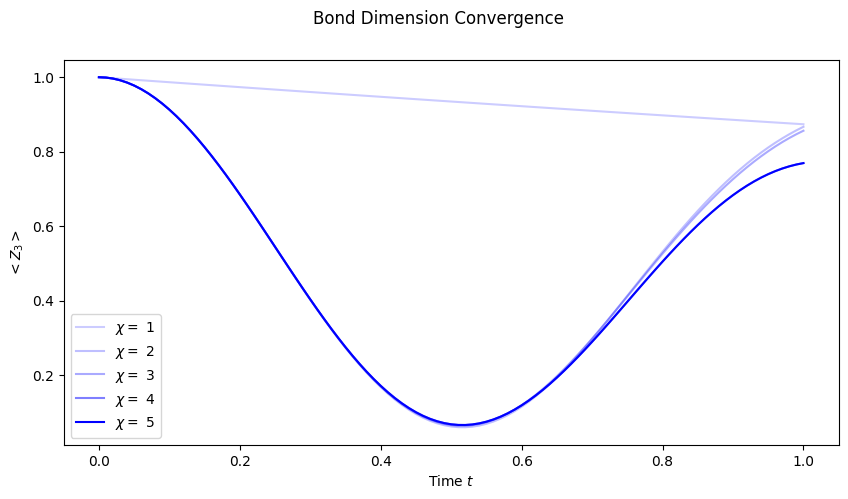

In [62]:
fig4, ax4 = plt.subplots(1, 1, sharex=True, figsize=(10,5))
fig4.suptitle("Bond Dimension Convergence")
cutoff = 5
for i, max_bond_dim in enumerate(max_bond_dims[:cutoff]):
    ax4.plot(times, results_mps[i,:], label=f"$\chi =$ {max_bond_dim}",
             color="b", alpha=1/(cutoff - i))
ax4.set_ylabel(f"$<Z_3>$")
ax4.set_xlabel("Time $t$")

plt.legend()
plt.show()

We can see that the dynamics converge with increasing bond-dimension and are fully converged for $\chi = 4$ for human perception, i.e. we can only make out four lines and not the five that were actually drawn.

In [63]:
error_bond_dim = np.zeros_like(results_mps)
for i in range(num_sites):
    error_bond_dim[i,:] = np.abs(exact_results[middle_site] - results_mps[i,:])

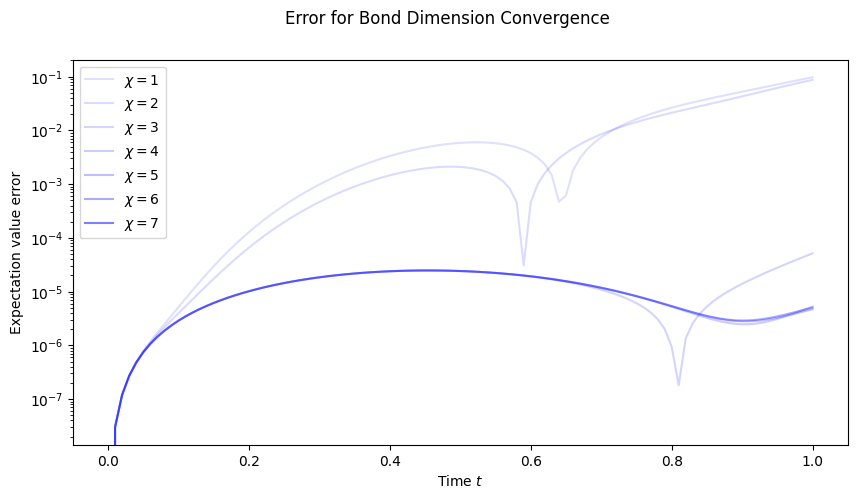

In [64]:
fig_bond_dim_error, ax_bond_dim_error = plt.subplots(1,1,figsize=(10,5))
fig_bond_dim_error.suptitle("Error for Bond Dimension Convergence")
cutoff = 8
for i in range(1,cutoff):
    ax_bond_dim_error.semilogy(times, error_bond_dim[i,:], label=f"$\chi =${i}",
                               color="b", alpha=1/(cutoff-i+1))
ax_bond_dim_error.set_xlabel("Time $t$")
ax_bond_dim_error.set_ylabel("Expectation value error")

plt.legend()
plt.show()

If we look at the actual error in a logscale we can find that the bond dimension still converges albeit with problems for certain points in time. It is certainly converged for a bond dimension of $\chi = 8$.

### Error Dependence on Time Step
For a fixed final time, the error of our dynamics should increase linearly with $\delta t$.

In [65]:
max_bond_dim = 7
svd_params = SVDParameters(max_bond_dim, rel_tol, renorm=False)
num_time_steps_range = range(10, 100, 1)
ref_result = exact_results[middle_site,-1]
results_mps = []
time_step_sizes = []

for i, num_time_steps in tqdm(enumerate(num_time_steps_range)):
    time_step_size = final_time / num_time_steps
    time_step_sizes.append(time_step_size)
    tebd_mps = TEBD(deepcopy(mps),
                    trotter1st,
                    time_step_size,
                    final_time,
                    tebd_operators[f"site{middle_site}"],
                    svd_parameters=svd_params)
    tebd_mps.run(pgbar=False, evaluation_time="inf")
    tebd_results = tebd_mps.operator_results(realise=True)[0,-1]
    results_mps.append(np.absolute(tebd_results - ref_result))


90it [00:09,  9.67it/s]


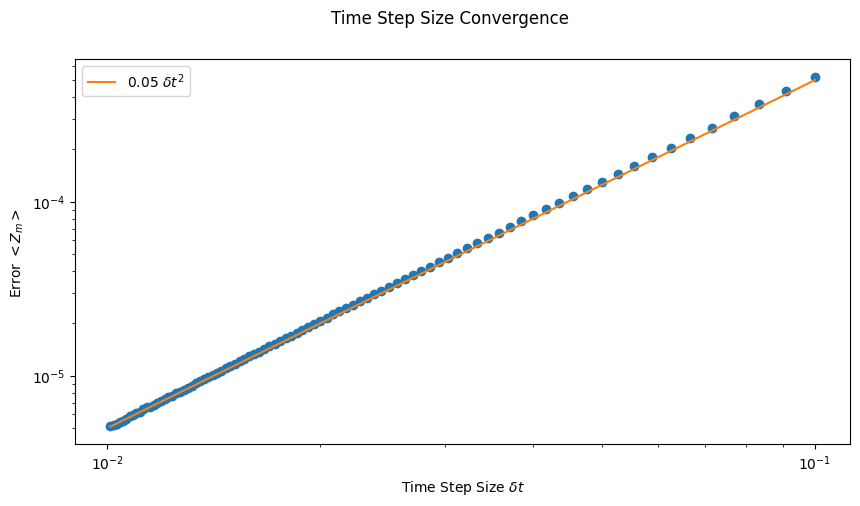

In [66]:
fig5, ax5 = plt.subplots(1, 1, sharex=True, figsize=(10,5))
fig5.suptitle("Time Step Size Convergence")

ax5.loglog(time_step_sizes, results_mps, "o")
ax5.loglog(time_step_sizes, [0.05*time_step_size**2 for time_step_size in time_step_sizes],
           label="$0.05 \, \,\delta t^2$")
ax5.set_ylabel(f"Error $<Z_m>$")
ax5.set_xlabel("Time Step Size $\delta t$")

plt.legend()
plt.show()